In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import time

#Scikit Learn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import  MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error



#TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Normalization
import keras_tuner as kt


%matplotlib inline

monster_df = pd.read_csv('../data/processed/Monster_modeling_df.csv')

monster_df.drop(columns={"Unnamed: 0", "Monster Name", "Size",'Type','Alignment'},axis=1, inplace=True)
monster_df.head()



,Traits,Reactions,Armor Class,Hit Points,Challenge,Proficiency Bonus,STR,DEX,CON,INT,...,chaotic good,chaotic neutral,lawful evil,lawful good,lawful neutral,neutral,neutral evil,neutral good,unaligned,total_stats
0,1,0,19,207,15.0,5,23,12,21,18,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,106
1,1,0,19,243,16.0,5,27,10,25,16,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,112
2,1,0,18,200,13.0,5,22,10,22,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86
3,1,0,15,90,5.0,3,14,20,14,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,70
4,0,0,12,19,0.5,2,16,14,14,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,69


In [2]:
#Input Variables: Size, Type, Environment, Alignment, CR(disguised as 4x player level)
#Output Variables: Stats, Saving Throws, Traits(barebones), Attack Bonus, Damage per Round, Reactions (y/n), Legendary Actions (y/n)

LinearRegression (and related)
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor (and related)

In [3]:
monster_df.columns

Index(['Traits', 'Reactions', 'Armor Class', 'Hit Points', 'Challenge',
       'Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA',
       'Legendary Actions', 'Attack_Bonus', 'Spell_Bonus', 'Spell_Save_DC',
       'WIS_SV', 'INT_SV', 'CHA_SV', 'STR_SV', 'DEX_SV', 'CON_SV', 'Arctic',
       'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill', 'Mountain', 'NA',
       'Swamp', 'Underdark', 'Underwater', 'Urban', 'Average_Damage_per_Round',
       'Damage Resistances', 'Damage Immunities', 'Condition Immunities',
       'Damage Vulnerabilities', 'Spellcaster', 'Magic Resistance',
       'Legendary Resistance', 'Regeneration', 'Undead Fortitude',
       'Pack Tactics', 'Damage Transfer', 'Angelic Weapons', 'Charge',
       'size_ordinal', 'aberration', 'beast', 'celestial', 'construct',
       'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid',
       'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment',
       'any chaotic alignment', 'any evil alignment', 

## MultOutput Machine Learning
Classic machine learning fails here since it generally maps multiple inputs to a single output. We could run independent regressions, predict each variable one at a time. This ignores correlations in the outputs however, so it isn't optimal.

We will try two methods: Random Forests with multioutput regressor and using Tensorflow Keras API

In [4]:
## Train Test Split

X_data = monster_df[['Coastal','Arctic','Desert','Forest','Grassland', 'Hill', 'Mountain', 'NA', 'Swamp', 'Underdark','Underwater', 'Urban','size_ordinal', 'aberration', 'beast','celestial', 'construct', 'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid', 'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment', 'any chaotic alignment', 'any evil alignment', 'any non-good alignment', 'any non-lawful alignment', 'chaotic evil', 'chaotic good', 'chaotic neutral', 'lawful evil', 'lawful good','lawful neutral', 'neutral', 'neutral evil', 'neutral good', 'unaligned','Challenge']]

y_data = monster_df[['Hit Points','Armor Class','Proficiency Bonus','STR','DEX','CON','WIS','INT','CHA', 'STR_SV','DEX_SV','CON_SV','WIS_SV','INT_SV','CHA_SV', 'Attack_Bonus','Average_Damage_per_Round','Legendary Actions', 'Damage Resistances', 'Damage Immunities', 'Condition Immunities', 'Damage Vulnerabilities', 'Legendary Resistance', 'Magic Resistance']]


feature_list = X_data.columns
target_list = y_data.columns

x_train, x_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.3,random_state=42)




## Linear Regression for Multioutput Regression

In [5]:
model = (LinearRegression())
model.fit(x_train, y_train)
print("Training Score: ", model.score(x_train, y_train))
print("Testing Score: ",model.score(x_test, y_test))
yhat_l = model.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_l))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_l))
scores = cross_val_score(model,X_data,y_data,cv=5)
print(scores.mean())

Training Score:  0.7137115581392551
Testing Score:  0.6056351821451139
Mean squared error: 50.46
Coefficient of determination: 0.61
0.5317739480983121


## k-Nearest Neighbors for Multioutput Regression

In [6]:
model_k = MultiOutputRegressor(KNeighborsRegressor())
model_k.fit(x_train, y_train)
print("Training Score: ", model_k.score(x_train, y_train))
print("Testing Score: ",model_k.score(x_test, y_test))
yhat_k = model_k.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_k))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_k))
scores = cross_val_score(model_k,X_data,y_data,cv=5)
print(scores.mean())


Training Score:  0.6909416913834311
Testing Score:  0.587280629588338
Mean squared error: 31.44
Coefficient of determination: 0.59
0.49103829885942335


## Multi Output Gradiant Boosting Regressor

In [7]:
model_g = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=75))
model_g.fit(x_train, y_train)
print("Training Score: ", model_g.score(x_train, y_train))
print("Testing Score: ",model_g.score(x_test, y_test))
yhat_g = model_g.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_g))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_g))
scores = cross_val_score(model_g,X_data,y_data,cv=5)
print(scores.mean())

Training Score:  0.8880738901532634
Testing Score:  0.6798827500339727
Mean squared error: 21.73
Coefficient of determination: 0.68
0.6304563006662703


## Random Forest Regression

In [8]:
n_est = 50
max_depth = 15
model_R = RandomForestRegressor(n_estimators = n_est,max_depth = max_depth, random_state=0)
model_R.fit(x_train, y_train)
print("Training Score: ", model_R.score(x_train, y_train))
print("Testing Score: ",model_R.score(x_test, y_test))
yhat_r = model_R.predict(x_test)

baseline_MSE = mean_squared_error(y_test, yhat_r)
baseline_r2 = r2_score(y_test, yhat_r)

print("Mean squared error: %.2f" % baseline_MSE)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % baseline_r2)


Training Score:  0.9259184314148653
Testing Score:  0.6278197300510371
Mean squared error: 23.52
Coefficient of determination: 0.63


## More info on Random Forest Regressor


In [9]:
## Feature Importance
feature_list = X_data.columns
# Get numerical feature importances
importances = list(model_R.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: Challenge            Importance: 0.87
Variable: size_ordinal         Importance: 0.07
Variable: dragon               Importance: 0.01
Variable: unaligned            Importance: 0.01
Variable: Coastal              Importance: 0.0
Variable: Arctic               Importance: 0.0
Variable: Desert               Importance: 0.0
Variable: Forest               Importance: 0.0
Variable: Grassland            Importance: 0.0
Variable: Hill                 Importance: 0.0
Variable: Mountain             Importance: 0.0
Variable: NA                   Importance: 0.0
Variable: Swamp                Importance: 0.0
Variable: Underdark            Importance: 0.0
Variable: Underwater           Importance: 0.0
Variable: Urban                Importance: 0.0
Variable: aberration           Importance: 0.0
Variable: beast                Importance: 0.0
Variable: celestial            Importance: 0.0
Variable: construct            Importance: 0.0
Variable: elemental            Importance: 0.0
Variable:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Baseline TensorFlow model Keras
Rather than train_test, we will use keras's validation split & validation data in order to split before modeling and then monitor test accuracy during training

In [10]:
# Turn data into numpy arrays
X = np.array(X_data)
Y = np.array(y_data)

In [11]:
#feature normlization will happen as part of keras preprocessing layer : Normalization
normalizer =  Normalization(axis=-1)
normalizer.adapt(X)

normalized_data = normalizer(X)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 1.0000
mean: 0.0000


In [12]:
# simple test model
x_train = np.array(x_train)
model = Sequential([
    normalizer,
    Dense(units=24)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 44)               89        
 n)                                                              
                                                                 
 dense (Dense)               (None, 24)                1080      
                                                                 
Total params: 1,169
Trainable params: 1,080
Non-trainable params: 89
_________________________________________________________________


In [13]:
model.predict(x_test)

array([[ 0.77173626,  0.3847485 , -0.932798  , ..., -1.2994401 ,
        -0.32914078,  0.67668116],
       [-1.0682352 , -1.6427388 , -0.56177497, ..., -0.6620686 ,
        -0.24640447,  1.6012719 ],
       [ 0.40196648,  1.8198375 , -1.214272  , ...,  0.36578813,
         0.22607026,  0.26501665],
       ...,
       [ 0.16630152, -0.35683262, -2.3541877 , ...,  0.16399844,
        -0.75146735,  0.0961467 ],
       [ 1.1840274 ,  0.06978813, -0.8935859 , ..., -1.886204  ,
        -0.5932608 ,  1.4367628 ],
       [ 1.3118902 ,  1.8898993 ,  1.0014156 , ...,  0.18662912,
        -0.06844151,  1.93534   ]], dtype=float32)

In [14]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [15]:
%%time
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose =0,
    validation_split = 0.2
)

CPU times: total: 5.72 s
Wall time: 5.64 s


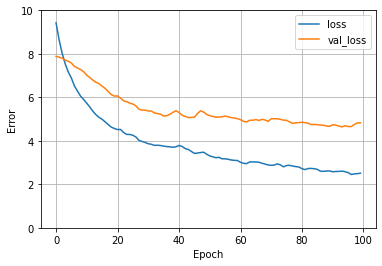

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [17]:
model.evaluate(x_test,y_test,verbose=0)

5.1992316246032715

In [57]:
def compile_model(n_inputs, n_outputs):
    model_tf = Sequential([
    normalizer])
    model_tf.add(Dense(44, input_dim = n_inputs, kernel_initializer = 'he_uniform', activation = 'relu'))
    model_tf.add(Dense(32, activation= "relu"))
    model_tf.add(Dense(n_outputs))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model_tf.compile(loss= "mean_squared_error" , optimizer=opt, metrics=['accuracy'])
    return model_tf
    

In [58]:
def cross_validate(X, y, K = 5, **kwargs):
    '''
    function adapted from yousefnami- towardsdatascience
    uses KFold validation to check that model works for different randomised conditions.
    '''
    scores = []
    histories = []
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model(44,24) # compile model
        start = time.time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]), # feed in the test data for plotting
                                   **kwargs).history)
        print(time.time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0)) # evaluate the test dataset
    print("average test loss: ", np.asarray(scores)[:,0].mean())
    print("average test accuracy: ", np.asarray(scores)[:,1].mean())
    print(model.summary())
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy', 'val_accuracy','val_loss']):
    """
    function adapted from yousefnami- towardsdatascience
    to plot the histories of data
    """
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].legend([i for i in range(len(histories))])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
                np.arange(max(history[metric]))
            )

In [20]:
#baseline model: average test loss:771, average test acc: 3.4%
scores, histories = cross_validate(X,Y)

9/9 [==============================] - 1s 44ms/step - loss: 711.8400 - accuracy: 0.0036 - val_loss: 1007.5641 - val_accuracy: 0.0000e+00
1.2122876644134521
9/9 [==============================] - 1s 31ms/step - loss: 811.8385 - accuracy: 0.6187 - val_loss: 533.2996 - val_accuracy: 0.4714
1.049086332321167
9/9 [==============================] - 1s 29ms/step - loss: 848.6400 - accuracy: 0.0000e+00 - val_loss: 479.3678 - val_accuracy: 0.0000e+00
1.0590887069702148
9/9 [==============================] - 1s 25ms/step - loss: 772.4865 - accuracy: 0.2724 - val_loss: 761.7694 - val_accuracy: 0.2174
0.8640708923339844
9/9 [==============================] - 1s 26ms/step - loss: 696.1659 - accuracy: 0.0538 - val_loss: 1058.4055 - val_accuracy: 0.1304
0.8470683097839355
average test loss:  768.0812866210938
average test accuracy:  0.16385093033313752
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

In [61]:
#hyperparameter tuning

scores_tune, histories_tune = cross_validate(X,Y,epochs=100,verbose=0, batch_size=16)

5.302496433258057
5.408446788787842
5.336440563201904
5.483421087265015
5.472373008728027
average test loss:  49.69316711425781
average test accuracy:  0.8390061974525451
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 44)               89        
 n)                                                              
                                                                 
 dense_282 (Dense)           (None, 44)                1980      
                                                                 
 dense_283 (Dense)           (None, 32)                1440      
                                                                 
 dense_284 (Dense)           (None, 24)                792       
                                                                 
Total params: 4,301
Trainable params: 4,212
Non-trainable params: 89
___________

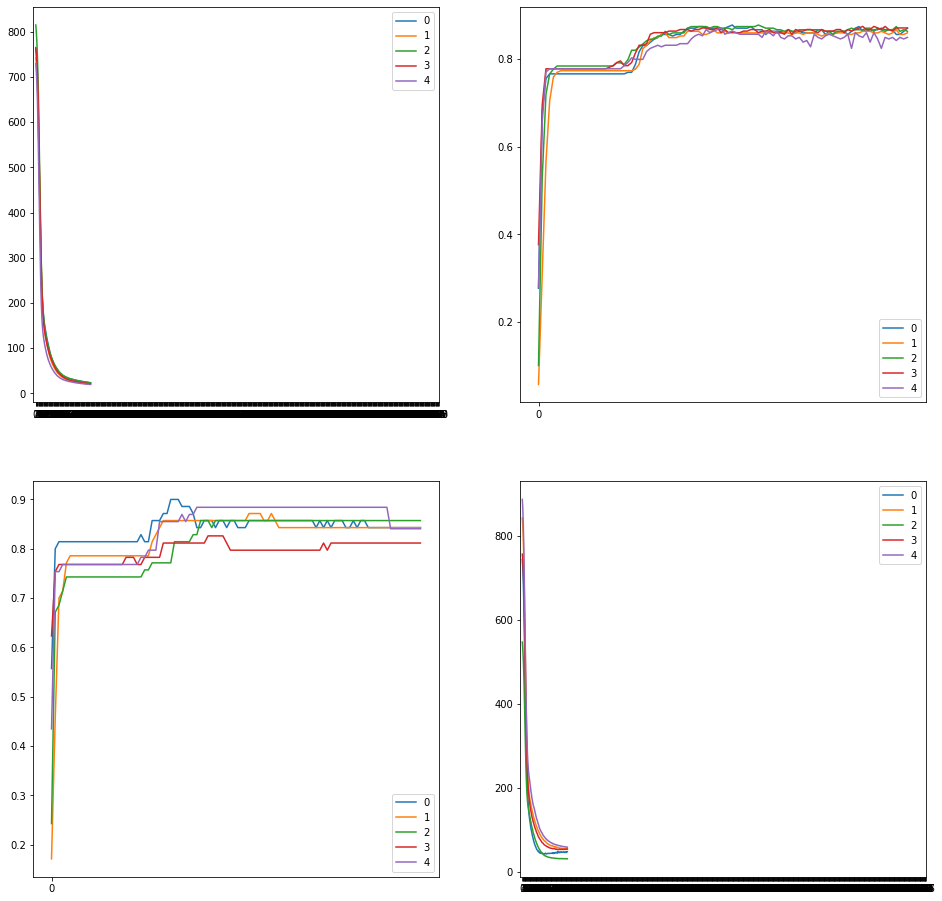

In [62]:
plot_histories(histories_tune)

## Model Tuning
Lets look at:
activation functio: relu and tanh
batch size: 16,32,64
epochs: 50, 100, 300
learning rate: 0.01, 0.001, and 0.0001


Trial #1: Epochs=100; Test Loss = 73.14, Test Acc = 78.7%, ~ 4-5 sec

Trial #2: Eppochs=300; Test Loss =68.48, Test Acc = 81.3%, ~12-13 sec

Trial #2: Epochs =50; Test Loss = 131.5, Test Acc = 77.6%, ~2-3 sec

Trial #4: Epochs = 50, bach_size=16; Test Loss = 91.9,  Test Accc = 77.9, ~3-4 sec

Trial # 5: """", batch_size =32, Test Loss =147.6; Test Acc =78.16, ~3-4 sec

Trial # 5: """", batch_size =64, Test Loss =297.16; Test Acc =70.13, ~2-3 sec

Trial # 6 """", activations: tahn,Test Loss = 719, Test Acc = 48.25  ,2-3 sec

Trial # 7 Epochs = 100, batch_size=16, activation = relu; Test Loss=62.18, Test Acc=80.75, 5-6 sec

Trial #8 "" "", Learning Rate: 0.01;Test Loss=201.77, Test Acc =83.89, 5-7 sec

Trial #9 """", Learning Rate: 0.001; Test Loss =54.94, Test Acc = 82.45% 5-6 sec

Trial #10 """", Learning Rate: 0.0001; Test Loss =617.34, Test Acc = 32.79% 5-6 

Trial #11 : Trial #9 with no hidden layers; Test Loss =92.36, Test Acc = 83.9%, 5-6 sec

**Trial #12: 1 Hidden layer, 32 units; Test Loss = 59.7 ,  Test Acc = 85.64%, 5-6 sec**

Trial #13: 2 HLs, 40, 30; Test Loss =81.62 , Test Acc = 85.3 , 5-6 sec

In [71]:
## Fit Final Model & Nested CV

model = compile_model(44,24)
history = model.fit(X, Y, epochs =100, batch_size =16)

Epoch 1/100
22/22 [==============================] - 1s 2ms/step - loss: 762.8212 - accuracy: 0.1552 
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 745.0366 - accuracy: 0.4684
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 717.7403 - accuracy: 0.6782
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 672.2537 - accuracy: 0.7500
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 609.3823 - accuracy: 0.7730
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 540.6666 - accuracy: 0.7759
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 465.8073 - accuracy: 0.7759
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 386.9359 - accuracy: 0.7759
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 310.3730 - accuracy: 0.7759
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 248.2227 - accur

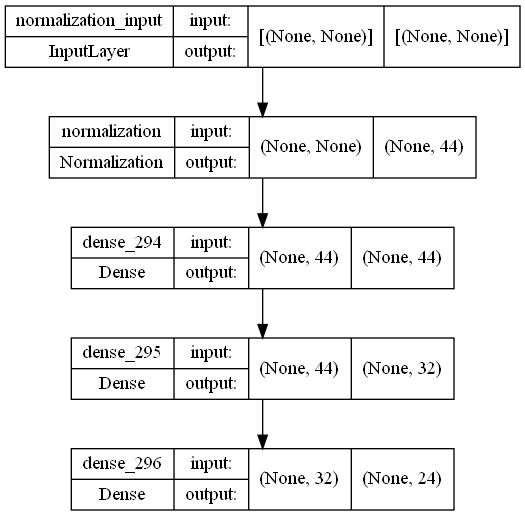

In [74]:
keras.utils.plot_model(model,"monster_model.png",show_shapes=True)

In [75]:
model.save("monster_generator.h5") 